## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# change path to reflect your env
%cd /content/gdrive/MyDrive/ml-final/ML-Final-Project
! pip3 install -r requirements.txt

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ml-final/ML-Final-Project/src')
sys.path.append('/content/drive/MyDrive/ml-final/ML-Final-Project/src/utils')

%cd /content/gdrive/MyDrive/ml-final/ML-Final-Project/src

In [ ]:
#!pip install numpy --upgrade
!pip install cebra
#!pip install h5py

In [ ]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import joblib as jl
import cebra.datasets
from cebra import CEBRA
from utils.nets import *
from utils.model_tools import *
import utils.ciivae_etc as UTIL
from scipy.ndimage import gaussian_filter1d

In [ ]:
!pip install 'cebra[datasets,demos]'
#os.environ['CEBRA_DATADIR'] = "./data"

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 420

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
ls data/rat_hippocampus/

## Import data/Preprocess

In [36]:
DATA_NAME = 'rat-hippocampus-achilles-3fold-trial-split-0'
offset_right = 5
offset_left = 5

def _call_dataset(offset_right, offset_left, split):
    dataset = cebra.datasets.init(DATA_NAME, split = split)
    dataset.offset.right = offset_right
    dataset.offset.left = offset_left
    return dataset

train_set = _call_dataset(offset_right, offset_left, 'train')
valid_set = _call_dataset(offset_right, offset_left, 'valid')
test_set = _call_dataset(offset_right, offset_left, 'test')

In [43]:
from torch.utils.data import TensorDataset, DataLoader

def make_loader(dataset, batch_size):
    tensor_dataset = TensorDataset(dataset[torch.arange(len(dataset))], dataset.index)
    dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
    return tensor_dataset, dataloader

train_dataset, train_loader = make_loader(train_set, 200)
valid_dataset, valid_loader = make_loader(valid_set, 200)
test_dataset, test_loader = make_loader(test_set, 200)

train_features, train_labels = next(iter(train_loader))
print(train_features[0].shape)
print(train_labels[0].shape)

torch.Size([120, 10])
torch.Size([3])


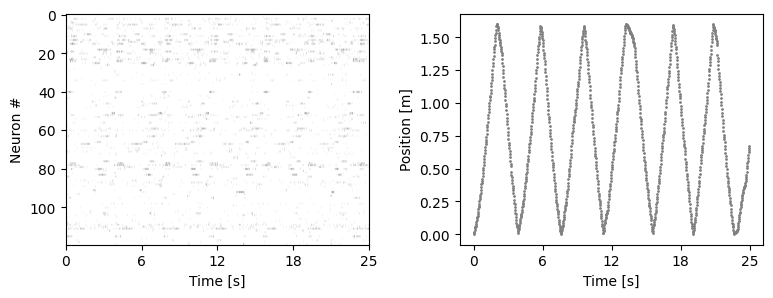

(6885, 120)


In [38]:
fig = plt.figure(figsize=(9,3))
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(train_set.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), train_set.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

print(train_set.neural.numpy().shape)

## Train CI-iVAE

In [ ]:
device = 'cpu'

ci_ivae = CIiVAE(dim_x=train_set.neural.shape[1], dim_u=3, dim_z=2) #CONV_iVAE.ConvCIiVAE(dim_x=train_set.neural.shape[1], dim_u=3, dim_z=2)

# train_x is a list of batches typically handled by the loader. TODO figure out how to do that in our implementation
# also: they say something about applying the pi-vae preprocessing script to this data
# it's unclear if they actually run the script while loading it or if we should
# but that code is available so if we need to it's not a big deal

dataloader_dict = {}
dataloader_dict['train'] = train_loader
dataloader_dict['val'] = valid_loader
dataloader_dict['test'] = test_loader

# # train CI-iVAE networks. Results will be saved at the result_path
fit(model=ci_ivae, dataloader_dict=dataloader_dict, seed=seed)
#CONV_iVAE.fit(model=ci_ivae, x_train=train_x, u_train=train_u,
#            x_val=valid_x, u_val=valid_u, seed=seed)

## Load CI-iVAE and evaluate

In [39]:
model_file = 'results/ci_ivae-time=4-27-0-45-58/model.pth'

ci_ivae = CIiVAE(dim_x=train_set.neural.shape[1], dim_u=3, dim_z=2)

state_dict = torch.load(model_file, map_location=torch.device('cpu'))

ci_ivae[0] = state_dict['prior']
ci_ivae[1] = state_dict['encoder']
ci_ivae[2] = state_dict['decoder']

In [58]:
# Outputs: post_mean, post_log_var, z_sample, fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
from utils.model_tools import extract_feature, generate_z

# I don't understand the sampling -- do I need to do that?
def evaluate_ciivae(model, x, u, sigma=9/6, device='cpu'):
    # feed all in at once
    prior, encoder, decoder = model
    
    prior.eval()
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        lam_mean, lam_log_var = prior(u)
        x_reshape = torch.transpose(x, 1, 2)
        fire_rate = torch.squeeze(UTIL.gaussian_conv(x_reshape, sigma, device='cpu'))

        z_mean, z_log_var = encoder(fire_rate)

        z_mean = torch.squeeze(z_mean)
        z_log_var = torch.squeeze(z_log_var)
        post_mean, post_log_var = UTIL.compute_posterior(z_mean, z_log_var, lam_mean, lam_log_var)
    
        return post_mean, z_mean

print(train_set[torch.arange(len(train_set))].shape)
#print(type(train_u))
#print(train_u.shape)
post_mean, z_mean = evaluate_ciivae(ci_ivae, train_set[torch.arange(len(train_set))], train_set.index)
print(post_mean.shape)
print(z_mean.shape)
labels = train_set.index.numpy()
print(labels.shape)

torch.Size([6885, 120, 10])
torch.Size([6885, 2])
torch.Size([6885, 2])
(6885, 3)


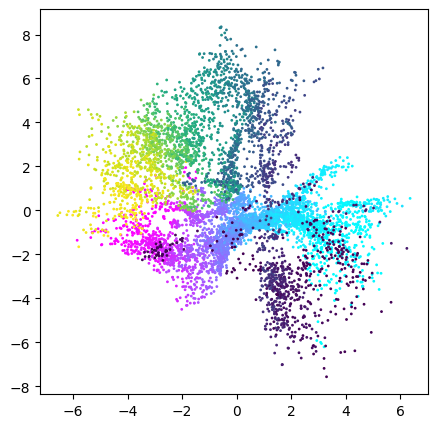

In [59]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
r_ind = labels[:,1] == 1
l_ind = labels[:,2] == 1
ax.scatter(post_mean[r_ind, 0], post_mean[r_ind, 1], c=labels[r_ind,0], s=1, cmap = 'cool')
ax.scatter(post_mean[l_ind, 0], post_mean[l_ind, 1], c=labels[l_ind,0], s=1, cmap = 'viridis')